In [54]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs, Predictive

from jax import random
import jax
import jax.numpy as jnp
import torch

In [23]:
import skbio 
import numpy as np

In [24]:
fref_in='../../test_data/super_small_ex/ref.fasta'
freads_in='../../test_data/super_small_ex/seqs.fasta'

In [25]:
def seq_mapping(seq, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    mapped = []
    for base in seq:
            mapped.append(alphabet.find(base))
    return np.array(mapped)

def fasta2ref(fref_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    for seq in skbio.io.read(fref_in, format='fasta'):
        ref = seq_mapping(str(seq), alphabet)
    return ref

def fasta2reads(freads_in, alphabet):
    # Coding scheme
    # 0:A, 1:C, 2:G, 3:T 4:- (NOT YET:, 5:N)
    reads_mapped = []
    for seq in skbio.io.read(freads_in, format='fasta'):
        reads_mapped.append(seq_mapping(str(seq), alphabet))
    return np.array(reads_mapped)

In [26]:

alphabet ='ACGT-'
B = len(alphabet) # size alphabet

# Coding scheme
# 0:A, 1:C, 2:G, 3:T 4:-, 5:N

ref = fasta2ref(fref_in, alphabet)
reads = fasta2reads(freads_in, alphabet) # what about non-unique reads ? 

L=ref.shape[0] # length of genome
N=reads.shape[0] # number of reads

### Simplyfied model with fixed hyperparameters

ref = reference sequence  
$N$ = number of reads  
$K$ = number of clusters/components  
$L$ = genome length (number of positions)
alphabet = {A, C, G, T, -}

Fixed parameters: 
* mutation rate: $1- \gamma$
* error rate: $1-\theta$
* Dirichlet prior: $\alpha = (\alpha_1, ..., \alpha_k)$

Cluster weights ($K$-dim): $\pi | \alpha \sim Dir(\alpha)$  
Cluster assignments ($N$-dim): $z|\pi \sim Categorical(\pi)$  
Cluster centers/haplotypes ($K$x$L$-dim): $h | ref, \gamma \sim Categorical(W) $ 
with $W(l,i)=
\begin{cases} 
\gamma,  \text{ if }i = ref[l] \\
\frac{1-\gamma}{4}, \text{ else. }
\end{cases}$ for $l \in {1, ..., L}$ and $i\in {1,..., |alphabet|}$  
Likelihood of the reads ($N$-dim): $r | z, h, \theta \sim Categorical(E)$ 
with $E(n,l,i)=
\begin{cases} 
\theta,  \text{ if }i = h_{z_n}[l] \\
\frac{1-\theta}{4}, \text{ else. }
\end{cases}$ for $n \in {1, ..., N}$, $l \in {1, ..., L}$ and $i\in {1,..., |alphabet|}$  



In [27]:
K = 10  # Fixed number of components

# fixed constants
gamma = 0.70
theta = 0.99    


L=ref.shape[0] # length of genome
N=reads.shape[0] # number of reads
B = len(alphabet)

# --- Mutation matrix ----
# LxB-dimensional
weight = np.full((L,B),(1-gamma)/(B-1))
np.put_along_axis(weight, ref.reshape(L,1), gamma, axis=1) # is written into weight
# KxLxB dimensional 
ref_gamma_weight = np.array(K*[weight]) # KxLxB 

# --- Error matrix --- 
# NxLxB dimensional 
weight_theta = np.full((N,L,B),(1-theta)/(B-1))


#@config_enumerate
def model(reads): # reads is N x L dimensional 
    
    # hyperparameter
    alpha = np.ones(K)/K
    
    pi = numpyro.sample('pi', dist.Dirichlet(alpha))
    
    genome_axis = numpyro.plate('genome_axis', L, dim=-1)
    with numpyro.plate('haplo_axis', K, dim=-2):
        with genome_axis:
            h = numpyro.sample('h', dist.Categorical(ref_gamma_weight))
            print('h ', h.shape)
    
    with numpyro.plate('read_axis', N,dim=-2):
        z = numpyro.sample('z', dist.Categorical(pi))
        print('z ', h.shape)

        with genome_axis:
            weight_theta = np.full((N,L,B),(1-theta)/(B-1))
            np.put_along_axis(weight_theta, h[z].reshape(N,L,1), theta, axis=2)
            print('weight_theta ', weight_theta.shape)
            numpyro.sample('obs', dist.Categorical(weight_theta), obs=reads) # N x L dimensional 
            
    #print(f"     pi.shape = {pi.shape}")
    #print(f"     h.shape = {h.shape}")
    #print(f"     z.shape = {z.shape}")
    

In [28]:
print('genome lengt = L =', L)
print('number of reads = N =', N) # number of reads
print('lenght of alphabet = B =', B)

genome lengt = L = 7
number of reads = N = 7
lenght of alphabet = B = 5


In [29]:
rng_key = jax.random.PRNGKey(0)

num_warmup, num_samples = 1000, 2000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(
    DiscreteHMCGibbs(kernel),
    num_warmup=num_warmup,
    num_samples=num_samples,
)
mcmc.run(rng_key, reads)

h  (10, 7)
z  (10, 7)
weight_theta  (7, 7, 5)
h  (10, 7)
z  (10, 7)
weight_theta  (7, 7, 5)
h  (10, 7)
z  (10, 7)
weight_theta  (7, 7, 5)


  0%|                                                                                                                                                   | 0/3000 [00:00<?, ?it/s]


h  (10, 7)
z  (10, 7)


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ShapedArray(int32[7,7,1])>with<DynamicJaxprTrace(level=2/1)>
While tracing the function while_body_fun at /Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/jax/_src/lax/control_flow.py:139 for while_loop, this concrete value was not available in Python because it depends on the value of the argument 'loop_carry'.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

## Minimal case: Reduction to 1 position sequence

In [82]:
ref = jnp.array([0])
reads = jnp.array([[0], [1], [1], [1]])

input_data = ref, reads

cluster_num = 3

In [85]:
def model_1dim(input_data):
    reference, read_data = input_data

    # parameters
    read_count = read_data.shape[0]
    genome_length = 1
    alphabet_length = 2

    # define rates
    mutation_rate = numpyro.sample('mutation_rate', dist.Beta(1, 1))
    error_rate = numpyro.sample('error_rate', dist.Beta(1, 1))

    # create matrix of rates
    # mutation_rate_matrix = jnp.full((genome_length, alphabet_length), (1 - mutation_rate) / (alphabet_length - 1))
    # custom_put_along_axis(mutation_rate_matrix, reference.reshape(genome_length, 1), (1 - mutation_rate), axis=1)
    mutation_rate_matrix = jnp.array([mutation_rate, 1 - mutation_rate])

    alpha = jnp.ones(cluster_num) / cluster_num
    cluster_weights = numpyro.sample("cluster_weights", dist.Dirichlet(alpha))

    genome_axis = numpyro.plate("genome_axis", genome_length, dim=-1)
    with numpyro.plate("haplotype_axis", cluster_num, dim=-2):
        with genome_axis:
#             print(mutation_rate_matrix, mutation_rate_matrix.sum())
            haplotypes = numpyro.sample("haplotypes", dist.Categorical(mutation_rate_matrix))  # cluster centers

    with numpyro.plate("read_axis", read_count, dim=-2):
        #print(cluster_weights, cluster_weights.sum())
        #print((cluster_weights / cluster_weights.sum()).sum())
        #cluster_assignments = numpyro.sample("z", dist.Categorical(cluster_weights / cluster_weights.sum()))
        cluster_assignments = numpyro.sample("cluster_assignments", dist.Categorical(cluster_weights))

        with genome_axis:
            # error_rate_matrix = jnp.full((genome_length, alphabet_length), (1 - error_rate) / (alphabet_length - 1))
            # custom_put_along_axis(error_rate_matrix, haplotypes[cluster_assignments].reshape(read_count, genome_length, 1), 1 - error_rate, axis=2)
            error_rate_matrix = jnp.array([error_rate, 1 - error_rate])
            numpyro.sample("obs", dist.Categorical(error_rate_matrix), obs=read_data)

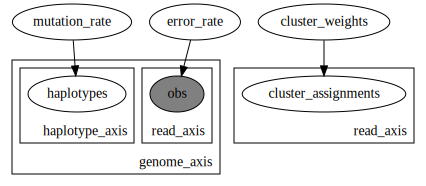

In [86]:
numpyro.render_model(model_1dim, model_args=(input_data,))

In [87]:
rng_key = jax.random.PRNGKey(0)

num_warmup, num_samples = 1000, 2000

# Run NUTS. How many chains? 
kernel = NUTS(model_1dim)
mcmc = MCMC(
    DiscreteHMCGibbs(kernel),
    num_warmup=num_warmup,
    num_samples=num_samples,
)
mcmc.run(rng_key, input_data)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:13<00:00, 223.38it/s, 15 steps of size 2.91e-01. acc. prob=0.93]


In [88]:
mcmc.print_summary()
# r_hat is the Gelman Rubin 


                              mean       std    median      5.0%     95.0%     n_eff     r_hat
cluster_assignments[0,0]      0.95      0.83      1.00      0.00      2.00    348.60      1.00
cluster_assignments[1,0]      1.00      0.83      1.00      0.00      2.00    353.14      1.01
cluster_assignments[2,0]      0.95      0.83      1.00      0.00      2.00    365.64      1.00
cluster_assignments[3,0]      0.96      0.83      1.00      0.00      2.00    318.60      1.00
      cluster_weights[0]      0.35      0.34      0.24      0.00      0.90    247.96      1.01
      cluster_weights[1]      0.32      0.32      0.18      0.00      0.85    273.22      1.00
      cluster_weights[2]      0.33      0.33      0.19      0.00      0.89    238.09      1.01
              error_rate      0.33      0.18      0.30      0.05      0.60    848.77      1.00
         haplotypes[0,0]      0.52      0.50      1.00      0.00      1.00    767.86      1.00
         haplotypes[1,0]      0.54      0.50     

In [89]:
posterior_samples = mcmc.get_samples()

In [93]:
posterior_samples

{'cluster_assignments': DeviceArray([[[0],
               [0],
               [0],
               [0]],
 
              [[0],
               [0],
               [0],
               [0]],
 
              [[1],
               [0],
               [1],
               [1]],
 
              ...,
 
              [[1],
               [0],
               [1],
               [2]],
 
              [[1],
               [1],
               [1],
               [1]],
 
              [[1],
               [1],
               [1],
               [0]]], dtype=int32),
 'cluster_weights': DeviceArray([[0.8406322 , 0.13787034, 0.02149746],
              [0.5146121 , 0.4528024 , 0.03258552],
              [0.2347455 , 0.7145509 , 0.05070356],
              ...,
              [0.04240171, 0.8081801 , 0.14941816],
              [0.13759522, 0.69864976, 0.16375497],
              [0.3299385 , 0.6574277 , 0.01263371]], dtype=float32),
 'error_rate': DeviceArray([0.30299464, 0.33238542, 0.22871609, ..., 0.1150120

In [ ]:
# understanding Predictive. 
# The predictive distirubtion is obtained by running model conditioned on latent samples from 
# posterior_samples p(theta | data)

In [90]:
# Make sure to infer_discrete
posterior_predictive = Predictive(model_1dim, posterior_samples, infer_discrete=True)
posterior_predictions = posterior_predictive(rng_key, input_data=input_data)

In [92]:
posterior_predictions

{'obs': DeviceArray([[[0],
               [1],
               [1],
               [1]],
 
              [[0],
               [1],
               [1],
               [1]],
 
              [[0],
               [1],
               [1],
               [1]],
 
              ...,
 
              [[0],
               [1],
               [1],
               [1]],
 
              [[0],
               [1],
               [1],
               [1]],
 
              [[0],
               [1],
               [1],
               [1]]], dtype=int32)}

In [91]:
# Add "cluster_assignments" values to mcmc samples
posterior_samples["cluster_assignments"] = posterior_predictions["cluster_assignments"]

KeyError: 'cluster_assignments'

In [94]:
inference_data = az.from_numpyro(
    posterior=mcmc,
    posterior_predictive=posterior_predictions,
)
display(inference_data)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

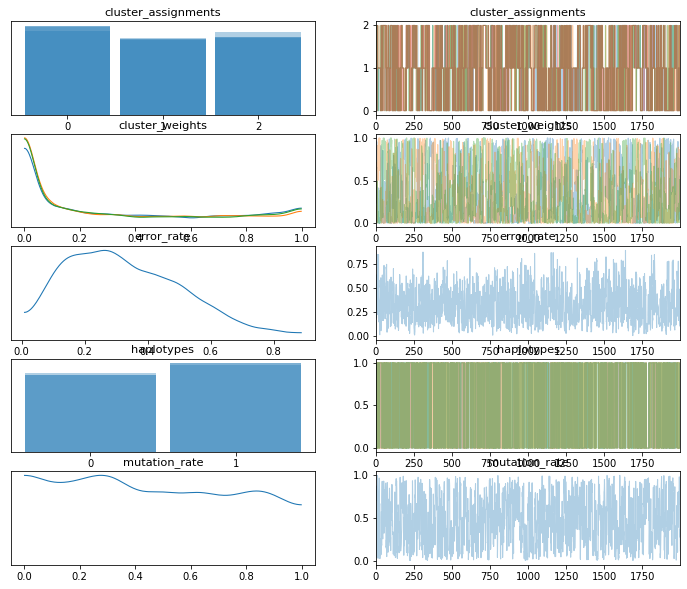

In [95]:
import arviz as az
import matplotlib.pyplot as plt

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True)
plt.show()